# Non-Karakoram Glaciers Data Analysis

The data used in this notebook was already imported and saved into our `data` directory as shown in the EDA notebook `EDA.ipynb`. For this notebook we analyze the Sít’ Kusá Glacier in Alaska and the Medvezhiy Glacier in Tajikistan and utilize the data in the `data/Other_Glaciers` directory.

In [1]:
%matplotlib inline

import glob
import xarray as xr
import rioxarray
import pandas as pd
import numpy as np
from datetime import datetime
import re
import matplotlib.pyplot as plt
import os
import matplotlib.gridspec as gridspec

def paths_to_datetimeindex(paths):
    """
    Extract the start and end date from each filename and return a pandas.DatetimeIndex.
    string_slice should give the full date range substring.
    Example substring: '20190606-20190622'
    """
    labels = []
    for p in paths:
        fname = p.split('/')[-1]
        dates = re.findall(r"\d{8}", fname)
        if len(dates) < 2:
            raise ValueError(f"File does not contain two dates: {fname}")
        start = pd.to_datetime(dates[0]).strftime("%Y-%m-%d")
        end = pd.to_datetime(dates[1]).strftime("%Y-%m-%d")
        labels.append(f"{start} - {end}")
    return labels

def midpoint(t):
    nums = re.findall(r"\d{4}\d{2}\d{2}", t.replace("-", ""))
    
    if len(nums) == 2:
        d1 = pd.to_datetime(nums[0])
        d2 = pd.to_datetime(nums[1])
        return d1 + (d2 - d1) / 2
    else:
        return pd.NaT

In [2]:
A_geotiff_list = glob.glob("data/Other_Glaciers/Alaska/*_vm_*.tif")

# Create variable used for time axis
A_time_var = xr.Variable('time', paths_to_datetimeindex(A_geotiff_list))

# Load in and concatenate all individual GeoTIFFs
A_geotiffs_da = xr.concat(
    [rioxarray.open_rasterio(i) for i in A_geotiff_list],
    dim=A_time_var
)

# Covert our xarray.DataArray into a xarray.Dataset
A_geotiffs_ds = A_geotiffs_da.to_dataset('band')

# Rename the variable to a more useful name
A_geotiffs_ds = A_geotiffs_ds.rename({1: 'x_vel', 2: 'y_vel', 3: 'vel_magnitude'})

#Adding midpoint time for sorting
A_mid_times = [midpoint(t) for t in A_geotiffs_ds.time.values]
A_geotiffs_ds = A_geotiffs_ds.assign_coords(mid_time=("time", A_mid_times))
A_geotiffs_ds = A_geotiffs_ds.sortby('mid_time')

Note: Variables beggining with 'A' such as `A_geotiff_ds` correspond to the Alaskan Glacier while variables begginging with 'T' correspond to the Tajikistan Glacier.

In [3]:
T_geotiff_list = glob.glob("data/Other_Glaciers/Tajikistan/*_vm_*.tif")

# Create variable used for time axis
T_time_var = xr.Variable('time', paths_to_datetimeindex(T_geotiff_list))

# Load in and concatenate all individual GeoTIFFs
T_geotiffs_da = xr.concat(
    [rioxarray.open_rasterio(i) for i in T_geotiff_list],
    dim=T_time_var
)

# Covert our xarray.DataArray into a xarray.Dataset
T_geotiffs_ds = T_geotiffs_da.to_dataset('band')

# Rename the variable to a more useful name
T_geotiffs_ds = T_geotiffs_ds.rename({1: 'x_vel', 2: 'y_vel', 3: 'vel_magnitude'})

#Adding midpoint time for sorting
T_mid_times = [midpoint(t) for t in T_geotiffs_ds.time.values]
T_geotiffs_ds = T_geotiffs_ds.assign_coords(mid_time=("time", T_mid_times))
T_geotiffs_ds = T_geotiffs_ds.sortby("mid_time")

Like we did with our Karakoram data, we need to trim our Tajikistan dataset to match the time interval of our smallest dataset(Alasakan Glacier). This is an important step to ensure that our comparisons are fair and accurate.

In [4]:
start = pd.to_datetime("2020-01-15")
end = pd.to_datetime("2021-10-17")

T_geotiffs_ds = T_geotiffs_ds.where(
    (T_geotiffs_ds.mid_time >= start) &
    (T_geotiffs_ds.mid_time <= end),
    drop=True)

In [5]:
A_mean_vx = A_geotiffs_ds.x_vel.mean(dim=['x','y'])
A_mean_vy = A_geotiffs_ds.y_vel.mean(dim=['x','y'])
A_mean_speed = A_geotiffs_ds.vel_magnitude.mean(dim=['x','y'])

A_summary_df = pd.DataFrame({
    'time': A_geotiffs_ds.time.values,
    'midpoint': A_geotiffs_ds.mid_time.values,
    'mean_vx': A_mean_vx.values,
    'mean_vy': A_mean_vy.values,
    'mean_vel_magnitude': A_mean_speed.values})


T_mean_vx = T_geotiffs_ds.x_vel.mean(dim=['x','y'])
T_mean_vy = T_geotiffs_ds.y_vel.mean(dim=['x','y'])
T_mean_speed = T_geotiffs_ds.vel_magnitude.mean(dim=['x','y'])

T_summary_df = pd.DataFrame({
    'time': T_geotiffs_ds.time.values,
    'midpoint': T_geotiffs_ds.mid_time.values,
    'mean_vx': T_mean_vx.values,
    'mean_vy': T_mean_vy.values,
    'mean_vel_magnitude': T_mean_speed.values})

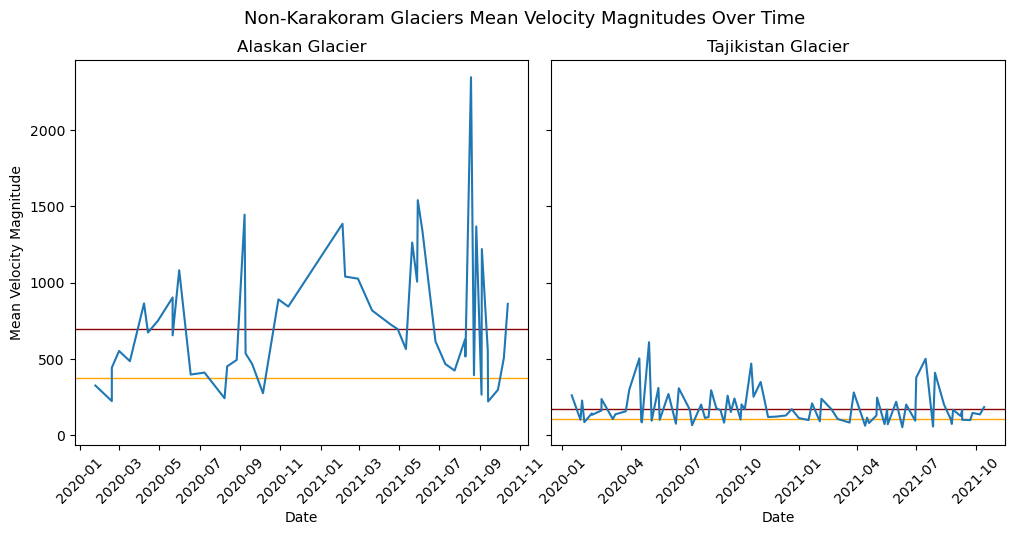

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12,5), sharey=True)

ax[0].axhline(y=A_geotiffs_ds['vel_magnitude'].mean(), color='darkred', linewidth=1)
ax[0].axhline(y=A_geotiffs_ds['vel_magnitude'].median(), color='orange', linewidth=1)
ax[0].plot(A_summary_df['midpoint'], A_summary_df['mean_vel_magnitude'])
ax[0].set_ylabel('Mean Velocity Magnitude')
ax[0].set_xlabel('Date')
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_title('Alaskan Glacier')

ax[1].axhline(y=T_geotiffs_ds['vel_magnitude'].mean(), color='darkred', linewidth=1)
ax[1].axhline(y=T_geotiffs_ds['vel_magnitude'].median(), color='orange', linewidth=1)
ax[1].plot(T_summary_df['midpoint'], T_summary_df['mean_vel_magnitude'])
ax[1].set_ylabel('')
ax[1].set_xlabel('Date')
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_title('Tajikistan Glacier')

plt.suptitle("Non-Karakoram Glaciers Mean Velocity Magnitudes Over Time", fontsize=13)
plt.subplots_adjust(wspace=0.05)
plt.savefig("figures/NK_meanmag_chart.png")
plt.show()

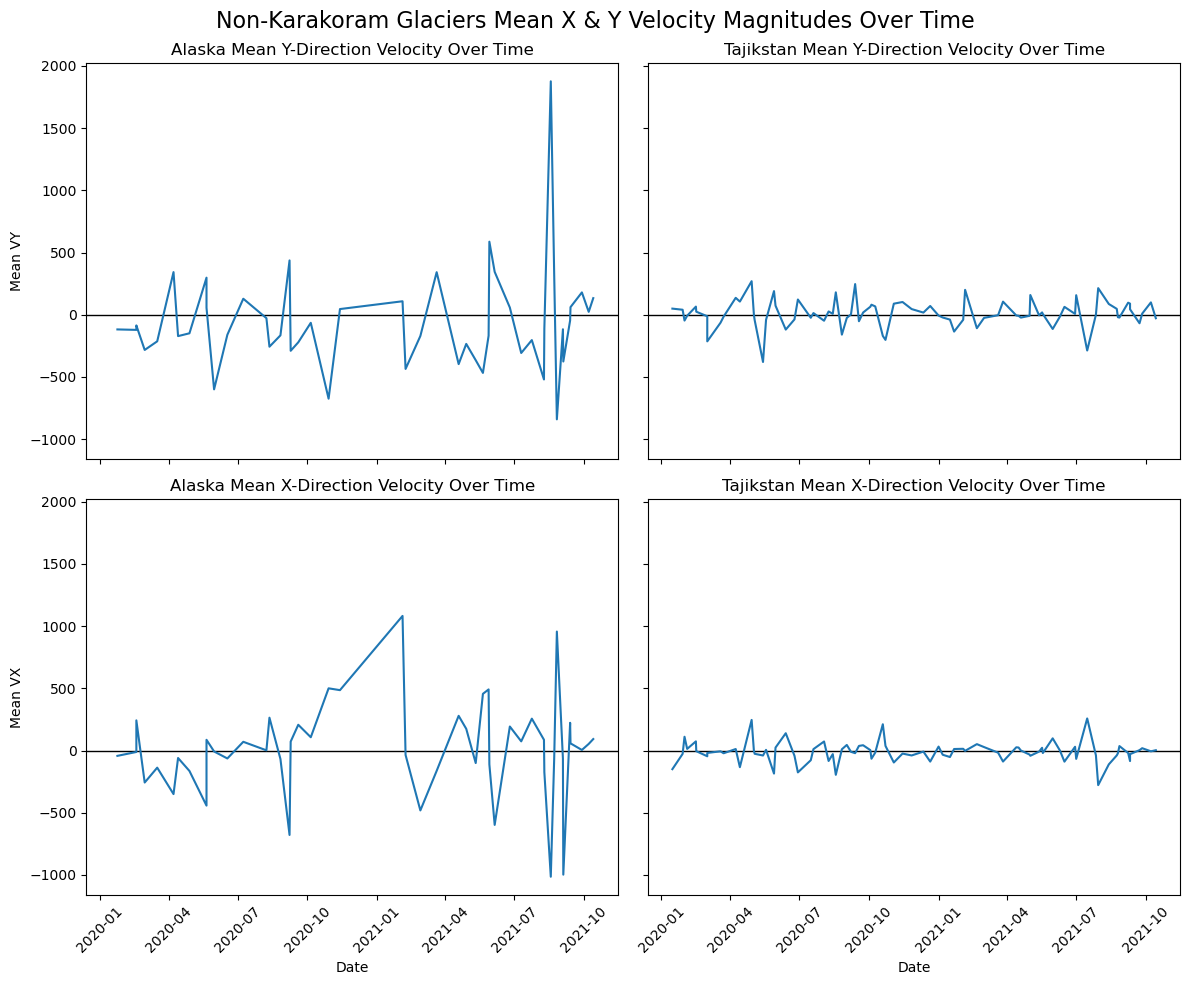

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(12,10), sharex=True, sharey=True)

ax[0,0].axhline(color='black', linewidth=1)
ax[0,0].plot(A_summary_df['midpoint'], A_summary_df['mean_vy'])
ax[0,0].set_ylabel('Mean VY')
ax[0,0].set_title('Alaska Mean Y-Direction Velocity Over Time')

ax[1,0].axhline(color='black', linewidth=1)
ax[1,0].plot(A_summary_df['midpoint'], A_summary_df['mean_vx'])
ax[1,0].set_ylabel('Mean VX')
ax[1,0].set_title('Alaska Mean X-Direction Velocity Over Time')
ax[1,0].set_xlabel('Date')

ax[0,1].axhline(color='black', linewidth=1)
ax[0,1].plot(T_summary_df['midpoint'], T_summary_df['mean_vy'])
ax[0,1].set_ylabel('')
ax[0,1].set_title('Tajikstan Mean Y-Direction Velocity Over Time')

ax[1,1].axhline(color='black', linewidth=1)
ax[1,1].plot(T_summary_df['midpoint'], T_summary_df['mean_vx'])
ax[1,1].set_ylabel('')
ax[1,1].set_title('Tajikstan Mean X-Direction Velocity Over Time')
ax[1,1].set_xlabel('Date')

for a in ax.ravel():
    a.tick_params(axis='x', rotation=45)

plt.suptitle("Non-Karakoram Glaciers Mean X & Y Velocity Magnitudes Over Time", fontsize=16)
plt.tight_layout()
plt.savefig("figures/NK_meanXY_chart.png")
plt.show()

In [8]:
A_monthly = A_geotiffs_ds.groupby("mid_time.month").mean()

A_monthly_mean_vx = A_monthly.x_vel.mean(dim=['x','y'])
A_monthly_mean_vy = A_monthly.y_vel.mean(dim=['x','y'])
A_monthly_mean_speed = A_monthly.vel_magnitude.mean(dim=['x','y'])

A_monthly_summary = pd.DataFrame({
    'month': A_monthly.month.values,
    'monthly_mean_vx': A_monthly_mean_vx.values,
    'monthly_mean_vy': A_monthly_mean_vy.values,
    'monthly_mean_vel_magnitude': A_monthly_mean_speed.values})


T_monthly = T_geotiffs_ds.groupby("mid_time.month").mean()

T_monthly_mean_vx = T_monthly.x_vel.mean(dim=['x','y'])
T_monthly_mean_vy = T_monthly.y_vel.mean(dim=['x','y'])
T_monthly_mean_speed = T_monthly.vel_magnitude.mean(dim=['x','y'])

T_monthly_summary = pd.DataFrame({
    'month': T_monthly.month.values,
    'monthly_mean_vx': T_monthly_mean_vx.values,
    'monthly_mean_vy': T_monthly_mean_vy.values,
    'monthly_mean_vel_magnitude': T_monthly_mean_speed.values})

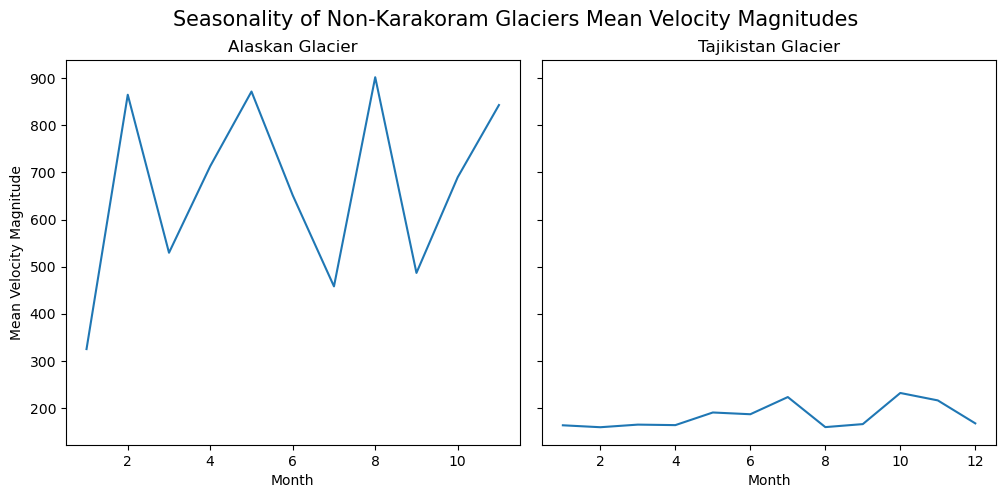

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12,5), sharey=True)

ax[0].plot(A_monthly_summary['month'], A_monthly_summary['monthly_mean_vel_magnitude'])
ax[0].set_ylabel('Mean Velocity Magnitude')
ax[0].set_xlabel('Month')
ax[0].set_title('Alaskan Glacier')

ax[1].plot(T_monthly_summary['month'], T_monthly_summary['monthly_mean_vel_magnitude'])
ax[1].set_ylabel('')
ax[1].set_xlabel('Month')
ax[1].set_title('Tajikistan Glacier')

plt.suptitle("Seasonality of Non-Karakoram Glaciers Mean Velocity Magnitudes", fontsize=15)
plt.subplots_adjust(wspace=0.05)
plt.savefig("figures/NK_seasonality_chart.png")
plt.show()

In [10]:
A_mean_vx_map = A_geotiffs_ds.x_vel.mean(dim='time')
A_mean_vy_map = A_geotiffs_ds.y_vel.mean(dim='time')
A_mean_speed_map = A_geotiffs_ds.vel_magnitude.mean(dim='time')

T_mean_vx_map = T_geotiffs_ds.x_vel.mean(dim='time')
T_mean_vy_map = T_geotiffs_ds.y_vel.mean(dim='time')
T_mean_speed_map = T_geotiffs_ds.vel_magnitude.mean(dim='time')

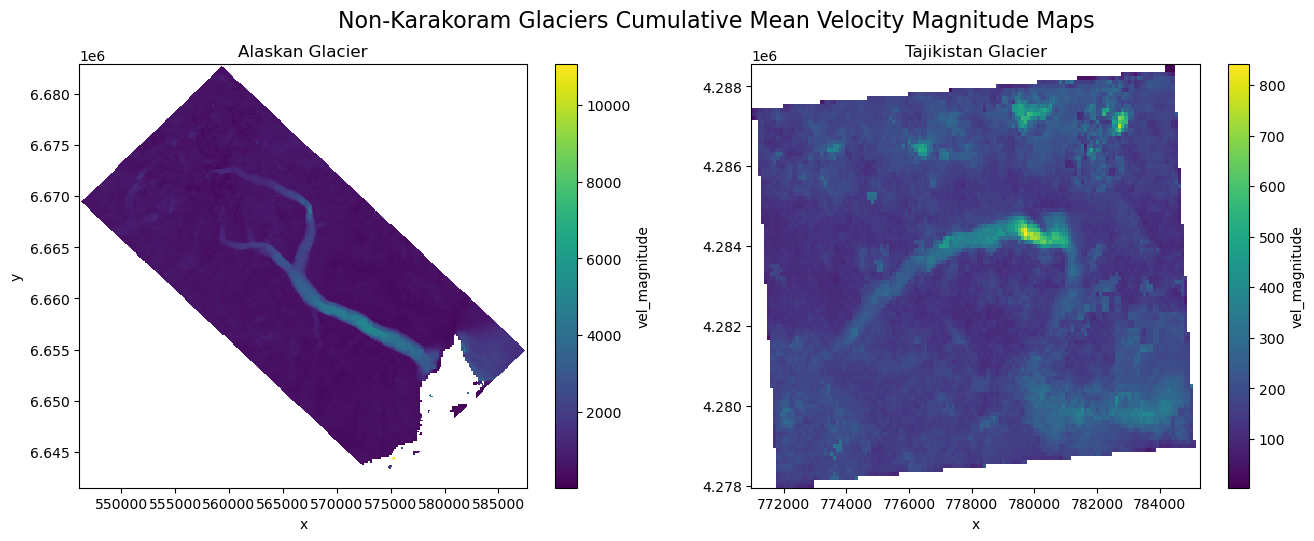

In [11]:
#vmax = max((A_mean_speed_map).max(), (T_mean_speed_map).max())
#vmin = min((A_mean_speed_map).min(), (T_mean_speed_map).min())

fig, axes = plt.subplots(1, 2, figsize=(17, 5.5))

A_mean_speed_map.plot(ax=axes[0])
axes[0].set_title("Alaskan Glacier")

T_mean_speed_map.plot(ax=axes[1])
axes[1].set_ylabel("")
axes[1].set_title("Tajikistan Glacier")

#cbar = fig.colorbar(mappable, ax=axes, orientation='vertical', fraction=0.04, pad=0.02)
#cbar.set_label("Velocity Magnitude")

plt.suptitle("Non-Karakoram Glaciers Cumulative Mean Velocity Magnitude Maps", fontsize=16)
plt.subplots_adjust(right = 0.85)
plt.savefig("figures/NK_meanmag_map.png")
plt.show()

In [12]:
A_trend_map = A_geotiffs_ds.vel_magnitude.polyfit(dim="mid_time", deg=1)
A_slope_map = A_trend_map.polyfit_coefficients.sel(degree=0)
A_slope_map = A_slope_map * 365

T_trend_map = T_geotiffs_ds.vel_magnitude.polyfit(dim="mid_time", deg=1)
T_slope_map = T_trend_map.polyfit_coefficients.sel(degree=0)
T_slope_map = T_slope_map * 365

/home/jovyan/.local/share/envs/glacier-env/lib/python3.12/site-packages/xarray/core/nputils.py:256: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


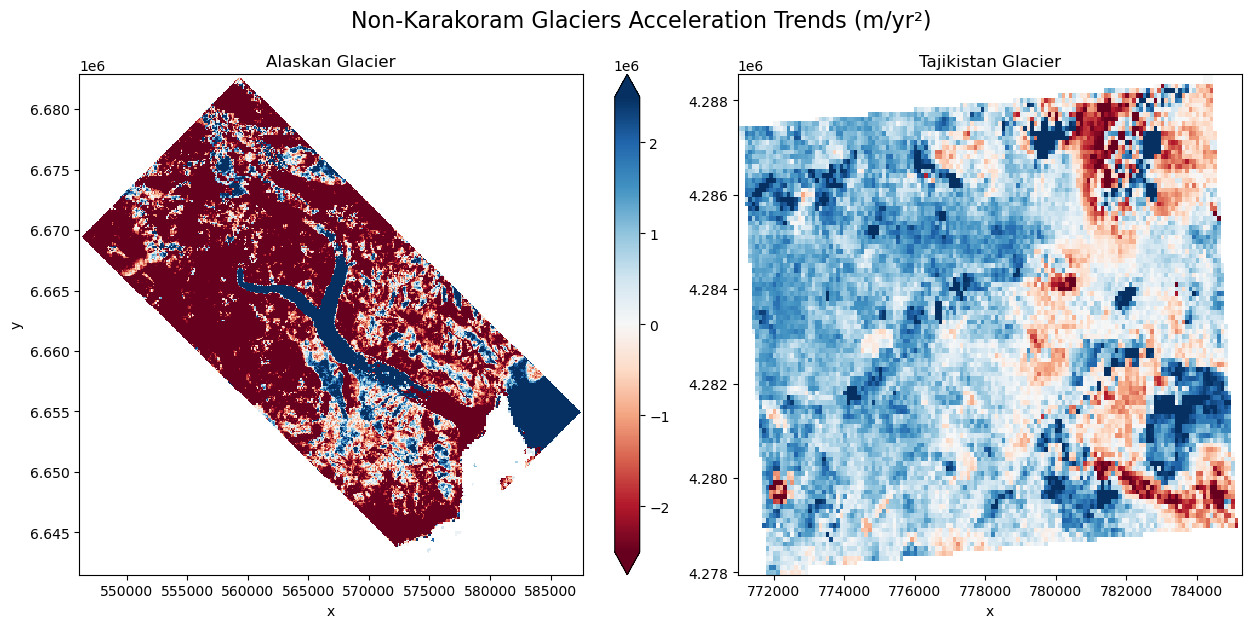

In [13]:
fig = plt.figure(figsize=(15, 6.5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1.25, 1]) 

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

p=A_slope_map.plot(ax=ax0, cmap='RdBu', vmin=-2500000, vmax=2500000)
p.colorbar.set_label("")
T_slope_map.plot(ax=ax1, cmap='RdBu', vmin=-2500000, vmax=2500000, add_colorbar=False)

ax0.set_title("Alaskan Glacier")
ax1.set_title("Tajikistan Glacier")
ax1.set_ylabel("")

plt.suptitle("Non-Karakoram Glaciers Acceleration Trends (m/yr²)", fontsize=16)
plt.subplots_adjust(wspace=0.05)
plt.savefig("figures/NK_acceleration_map.png")
plt.show()

This figure shows the non-Karakoram glacier's acceleration; the blue(positive) indicates acceleration while the red(negative) indicates deceleration.

In [14]:
A_vals = A_slope_map.values.flatten()
A_vals = A_vals[~np.isnan(A_vals)]

A_neg  = np.sum(A_vals < 0)
A_pos  = np.sum(A_vals > 0)

A_pct_neg  = A_neg / A_vals.size * 100
A_pct_pos  = A_pos / A_vals.size * 100

print("Alaska %Neg:", A_pct_neg)
print("Alaska %Pos:", A_pct_pos)

Alaska %Neg: 77.85167416004711
Alaska %Pos: 22.148325839952886


In [15]:
T_vals = T_slope_map.values.flatten()
T_vals = T_vals[~np.isnan(T_vals)]

T_neg  = np.sum(T_vals < 0)
T_pos  = np.sum(T_vals > 0)

T_pct_neg  = T_neg / T_vals.size * 100
T_pct_pos  = T_pos / T_vals.size * 100

print("Tajikistan %Neg:", T_pct_neg)
print("Tajikistan %Pos:", T_pct_pos)

Tajikistan %Neg: 22.75132275132275
Tajikistan %Pos: 77.24867724867724


Based on the plot and the outputs above we can see extremeley contrasting results between the two; while most of the Alaskan data is decelerating, the glacier itself is visibly accelerating. The results for Tajikistan data are much harder to interpret but we can see an overall trend of acceleration in the region. 